In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
])

all_train_data = torchvision.datasets.MNIST('.', train = True, download = True, transform = transform)
test_set = torchvision.datasets.MNIST('.', train = False, download = True, transform = transform)
train_size = int(0.9 * len(all_train_data))
train_set, val_set = torch.utils.data.random_split(all_train_data, [train_size, len(all_train_data) - train_size])

batch_size = 128
train_dataloader = DataLoader(train_set, batch_size = batch_size, shuffle = True)
val_dataloader = DataLoader(val_set, batch_size = batch_size, shuffle = False)
test_dataloader = DataLoader(test_set, batch_size = batch_size, shuffle = False)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 32938352.85it/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 1294572.03it/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 7883280.25it/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 7450343.67it/s]


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [ ]:
#DATA AUG

torch.Size([1, 28, 28])


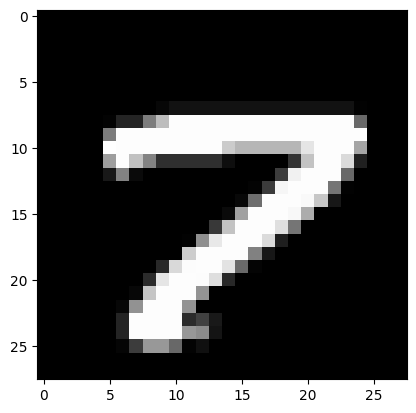

In [ ]:
#sample image
image, label = train_set[0]
plt.imshow(image.squeeze(), cmap = 'gray')
print(image.shape)

In [ ]:
class MLP(nn.Module):
    def __init__(self, num_classes):
        super(MLP, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(28 * 28, 100),
            nn.ReLU(),
            nn.Linear(100, num_classes)
        )
    def forward(self, x):
        return self.layers(torch.flatten(x, start_dim = 1))

    def predict(self, x):
        output = nn.Softmax()(self.forward(x))
        return torch.argmax(output, dim = 1)



In [ ]:
#hyperparams and model def
lr = 1e-4
epochs = 10
linear_model = MLP(10)
linear_model = linear_model.to(device)
optimizer = torch.optim.Adam(linear_model.parameters(), lr = lr)
loss_fn = nn.CrossEntropyLoss()
print(linear_model)

MLP(
  (layers): Sequential(
    (0): Linear(in_features=784, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=10, bias=True)
  )
)


In [ ]:
#training
train_loss = []
val_loss = []

for epoch in range(epochs):
    linear_model.train()
    epoch_train_loss = []
    epoch_val_loss = []
    for idx, batch in enumerate(train_dataloader):
        optimizer.zero_grad()
        imgs, labels = batch
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = linear_model.forward(imgs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        predictions = torch.argmax(outputs, dim = 1)
        epoch_train_loss.append(loss.item())
    train_loss.append(sum(epoch_train_loss) / len(epoch_train_loss))

    linear_model.eval()
    for idx, batch in enumerate(val_dataloader):
        with torch.no_grad():
            imgs, labels = batch
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = linear_model.forward(imgs)
            loss = loss_fn(outputs, labels)
            predictions = torch.argmax(outputs, dim = 1)
            epoch_val_loss.append(loss.item())
    val_loss.append(sum(epoch_val_loss) / len(epoch_val_loss))
    print(f"Epoch: {epoch}, Train Loss: {train_loss[len(train_loss) - 1]}, Val Loss: {val_loss[len(val_loss) - 1]}")

Epoch: 0, Train Loss: 1.6653767298748143, Val Loss: 1.0667739411195118
Epoch: 1, Train Loss: 0.7999866014408274, Val Loss: 0.616283543407917
Epoch: 2, Train Loss: 0.5387538516125973, Val Loss: 0.4679362438619137
Epoch: 3, Train Loss: 0.4378933926329229, Val Loss: 0.39902888983488083
Epoch: 4, Train Loss: 0.38507954091257396, Val Loss: 0.3596172605951627
Epoch: 5, Train Loss: 0.3528723292299921, Val Loss: 0.3330141405264537
Epoch: 6, Train Loss: 0.33042541153340543, Val Loss: 0.3149922446658214
Epoch: 7, Train Loss: 0.3139659914218984, Val Loss: 0.300196993475159
Epoch: 8, Train Loss: 0.30080599235414895, Val Loss: 0.28855747915804386
Epoch: 9, Train Loss: 0.28963598552473346, Val Loss: 0.27915033139288425


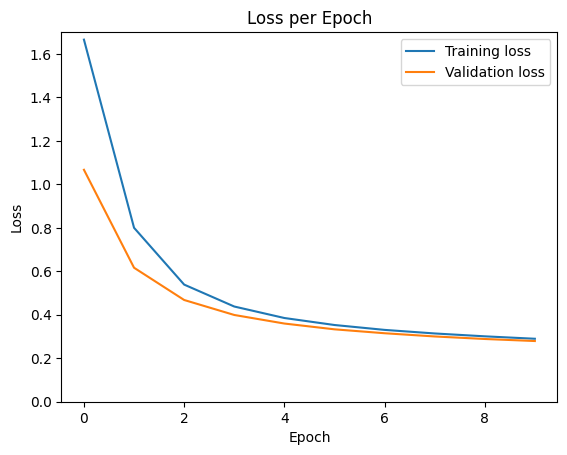

In [ ]:
#plots
plt.plot(train_loss, label='Training loss')
plt.plot(val_loss, label='Validation loss')
plt.legend()
plt.title('Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0, 1.7])
plt.show()

In [ ]:
#testing
accuracies = []
with torch.no_grad():
  for idx, batch in enumerate(test_dataloader):
    imgs, labels = batch
    imgs, labels = imgs.to(device), labels.to(device)
    outputs = linear_model.forward(imgs)
    predictions = torch.argmax(outputs, dim = 1)
    accuracies.append((predictions == labels).sum() / batch_size)
print((sum(accuracies) / len(accuracies)).item())

0.900195300579071


Prediction: 5 Actual Class: 5


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


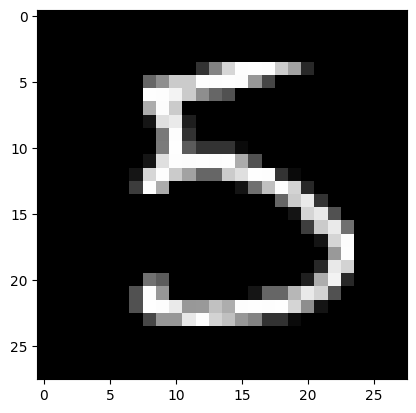

In [52]:
image, label = test_set[15]
linear_model = linear_model.to('cpu')
plt.imshow(image.squeeze(), cmap = 'gray')
print("Prediction:", linear_model.predict(image).item(), "Actual Class:", label)

In [4]:
class CNN(nn.Module):
  def __init__(self):
    super(CNN, self).__init__()
    self.conv1 = nn.Sequential(
        nn.Conv2d(1, 8, 3, 1, 1),
        nn.ReLU(),
        nn.MaxPool2d(2, 2)
    )
    self.conv2 = nn.Sequential(
        nn.Conv2d(8, 16, 2, 1, 1),
        nn.ReLU(),
        nn.MaxPool2d(2, 2)
    )
    self.conv3 = nn.Sequential(
        nn.Conv2d(16, 16, 2, 1, 1),
        nn.ReLU(),
        nn.MaxPool2d(2, 2)
    )
    self.fc = nn.Sequential(
        nn.Linear(4 * 4 * 16, 100),
        nn.ReLU(),
        nn.Linear(100, 10)
    )

  def forward(self, x):
    x = self.conv1(x)
    x = self.conv2(x)
    x = self.conv3(x)
    x = torch.flatten(x, start_dim = 1)
    return self.fc(x)
  def predict(self, x):
    x = self.conv1(x)
    x = self.conv2(x)
    x = self.conv3(x)
    x = torch.flatten(x, start_dim = 1)
    return self.fc(x)

In [5]:
#hyperparams and model def
lr = 1e-4
epochs = 50
conv_model = CNN()
conv_model = conv_model.to(device)
optimizer = torch.optim.Adam(conv_model.parameters(), lr = lr)
loss_fn = nn.CrossEntropyLoss()

In [6]:
#training
train_loss = []
val_loss = []

for epoch in range(epochs):
    conv_model.train()
    epoch_train_loss = []
    epoch_val_loss = []
    for idx, batch in enumerate(train_dataloader):
        optimizer.zero_grad()
        imgs, labels = batch
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = conv_model.forward(imgs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        predictions = torch.argmax(outputs, dim = 1)
        epoch_train_loss.append(loss.item())
    train_loss.append(sum(epoch_train_loss) / len(epoch_train_loss))

    conv_model.eval()
    for idx, batch in enumerate(val_dataloader):
        with torch.no_grad():
            imgs, labels = batch
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = conv_model.forward(imgs)
            loss = loss_fn(outputs, labels)
            predictions = torch.argmax(outputs, dim = 1)
            epoch_val_loss.append(loss.item())
    val_loss.append(sum(epoch_val_loss) / len(epoch_val_loss))
    print(f"Epoch: {epoch}, Train Loss: {train_loss[len(train_loss) - 1]}, Val Loss: {val_loss[len(val_loss) - 1]}")

/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch: 0, Train Loss: 1.8561075574131374, Val Loss: 0.9503521843159453
Epoch: 1, Train Loss: 0.7052423497088147, Val Loss: 0.5718308687210083
Epoch: 2, Train Loss: 0.5009350332462392, Val Loss: 0.44673529711175475
Epoch: 3, Train Loss: 0.4067840878785504, Val Loss: 0.382252388812126
Epoch: 4, Train Loss: 0.34939474329987974, Val Loss: 0.32995075780026456
Epoch: 5, Train Loss: 0.3084705464224115, Val Loss: 0.29249114971211615
Epoch: 6, Train Loss: 0.2760300068846811, Val Loss: 0.2664569800204419
Epoch: 7, Train Loss: 0.2506526190063682, Val Loss: 0.2436788560862237
Epoch: 8, Train Loss: 0.228803741264541, Val Loss: 0.22437179469047708
Epoch: 9, Train Loss: 0.21177445701654488, Val Loss: 0.20893541834455856
Epoch: 10, Train Loss: 0.1942361042044739, Val Loss: 0.19172480369501926
Epoch: 11, Train Loss: 0.18073191405472597, Val Loss: 0.18231852780631247
Epoch: 12, Train Loss: 0.1684156438044462, Val Loss: 0.16943476032069388
Epoch: 13, Train Loss: 0.15833554832679683, Val Loss: 0.158724952

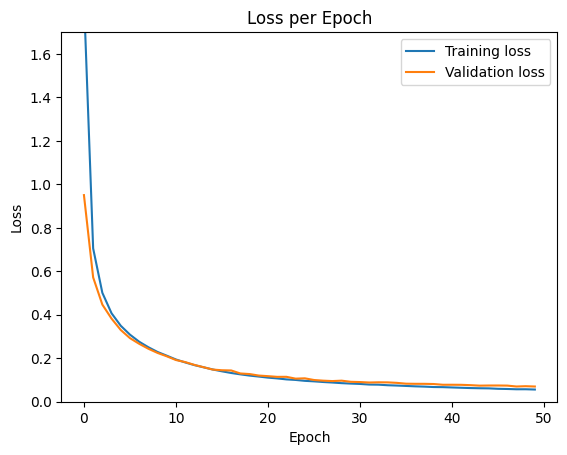

In [7]:
#plots
plt.plot(train_loss, label='Training loss')
plt.plot(val_loss, label='Validation loss')
plt.legend()
plt.title('Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0, 1.7])
plt.show()

In [8]:
#testing
accuracies = []
with torch.no_grad():
  for idx, batch in enumerate(test_dataloader):
    imgs, labels = batch
    imgs, labels = imgs.to(device), labels.to(device)
    outputs = conv_model.forward(imgs)
    predictions = torch.argmax(outputs, dim = 1)
    accuracies.append((predictions == labels).sum() / batch_size)
print((sum(accuracies) / len(accuracies)).item())

0.9701344966888428


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
